## Importing libraries

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
import igraph as ig

import matplotlib.pyplot as plt
import seaborn as sns
import folium

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

2023-03-02 17:01:07 Configured OSMnx 1.1.1
2023-03-02 17:01:07 HTTP response caching is on


## Loading dissolved roads from hex within 2km buffer

<AxesSubplot:>

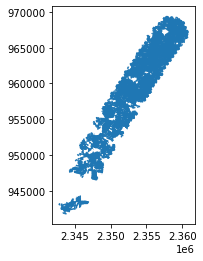

In [153]:
roads_2km  = gpd.read_file("../../data/external/db_segundopiso_temp/marcogeo_ejesviales_2km.gpkg")
roads_2km.plot()

In [154]:
print(roads_2km.shape)
roads_2km.head(2)

(21389, 12)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry
0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((2356137.273 967663.731, 2356..."
1,140390001,14,039,0001,03975,00008,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((2356686.712 967789.121, 2356..."


In [155]:
## Saving unique street ID
roads_2km_st = roads_2km.reset_index()
roads_2km_st = roads_2km_st.rename(columns={'index':'streetid'})
print(roads_2km.shape)
roads_2km_st.head(2)

(21389, 12)


,streetid,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry
0,0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((2356137.273 967663.731, 2356..."
1,1,140390001,14,039,0001,03975,00008,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((2356686.712 967789.121, 2356..."


## Generating public transport routes by street map

10m Buffer to streets

<AxesSubplot:>

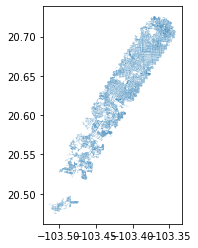

In [156]:
#Creating 10m buffer geometry on existing roads gdf
roads_2km_st = roads_2km_st.to_crs("EPSG:6372")
buffered_roads_2km = roads_2km_st.copy()
buffered_roads_2km['geometry'] = buffered_roads_2km.geometry.buffer(10)
buffered_roads_2km = buffered_roads_2km.to_crs("EPSG:4326")
buffered_roads_2km.plot()

In [157]:
print(buffered_roads_2km.shape)
buffered_roads_2km.head(2)

(21389, 13)


,streetid,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry
0,0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,"POLYGON ((-103.38430 20.71069, -103.38217 20.7..."
1,1,140390001,14,039,0001,03975,00008,Patria,Avenida,Dos sentidos,2,Urbana,"POLYGON ((-103.38060 20.71130, -103.38059 20.7..."


### Intersection of GDL Public routes with buffered streets

<AxesSubplot:>

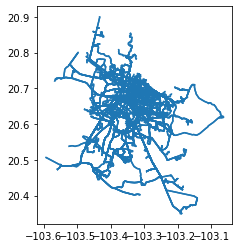

In [158]:
routes_gdl  = gpd.read_file("../../data/external/db_segundopiso_temp/rutastransporte_gdl.gpkg")
routes_gdl.plot()

In [159]:
print(routes_gdl.shape)
routes_gdl.head(2)

(449, 4)


,Tipo_de_se,Clasificac,Clasifica0,geometry
0,Complementaria,Rutas complementarias y otros servicios,Operando,"MULTILINESTRING ((-103.28542 20.61928, -103.28..."
1,Complementaria,Rutas complementarias y otros servicios,Operando,"MULTILINESTRING ((-103.25951 20.68500, -103.25..."


Intersecting routes over buffered roads

In [160]:
intersect_gdf = gpd.overlay(buffered_roads_2km,routes_gdl,keep_geom_type=False)

In [161]:
fields_tokeep = ['Tipo_de_se','Clasificac','Clasifica0','streetid']
intersect_gdf = intersect_gdf[fields_tokeep]
print(intersect_gdf.shape)
intersect_gdf.head(2)

(30930, 4)


,Tipo_de_se,Clasificac,Clasifica0,streetid
0,Complementaria,Rutas complementarias y otros servicios,Operando,0
1,Complementaria,Rutas complementarias y otros servicios,Operando,10


### Grouping routes by street number and joining with original street geo

In [162]:
#Counting routes_count by street
routes_bystreet = intersect_gdf.groupby('streetid').count()
routes_bystreet = routes_bystreet.reset_index().rename(columns={'Tipo_de_se':'routes_count'})
routes_bystreet_f = routes_bystreet[['streetid','routes_count']].copy()

print(routes_bystreet_f.shape)
routes_bystreet_f.head()

(5311, 2)


,streetid,routes_count
0,0,4
1,1,2
2,4,14
3,5,18
4,6,2


In [163]:
# Joining with original roads_2km_st geometry
routes_bystreetgdf = pd.merge(roads_2km_st,routes_bystreet_f, on='streetid',how='outer')

#Finding None values in 'routes_count' and changing them to 0
#Boolean mask
idx = routes_bystreetgdf['routes_count'].isna()
#Change where boolean mask
routes_bystreetgdf.loc[idx, 'routes_count'] = 0


routes_bystreetgdf = gpd.GeoDataFrame(routes_bystreetgdf, geometry='geometry')
routes_bystreetgdf

,streetid,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry,routes_count
0,0,140390001,14,039,0001,03975,00007,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((2356137.273 967663.731, 2356...",4.0
1,1,140390001,14,039,0001,03975,00008,Patria,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((2356686.712 967789.121, 2356...",2.0
2,2,140390001,14,039,0001,03149,00001,Francisco Seles,Privada,Dos sentidos,2,Urbana,"MULTILINESTRING ((2355206.594 961653.772, 2355...",0.0
3,3,140390001,14,039,0001,00184,00003,Teatro de la República,Calle,Un sentido,1,Urbana,"MULTILINESTRING ((2354375.691 964530.075, 2354...",0.0
4,4,140390001,14,039,0001,04035,00002,Fray Antonio Alcalde,Avenida,Dos sentidos,2,Urbana,"MULTILINESTRING ((2360249.160 966974.827, 2360...",14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21384,21384,141200001,14,120,0001,18519,00001,Ninguno,Calle,Dos sentidos,2,Urbana,"MULTILINESTRING ((2352508.763 955622.952, 2352...",0.0
21385,21385,141200001,14,120,0001,18517,00002,Lázaro Cárdenas,Calle,Dos sentidos,2,Urbana,"MULTILINESTRING ((2352340.473 955652.437, 2352...",0.0
21386,21386,141200001,14,120,0001,18517,00001,Lázaro Cárdenas,Calle,Dos sentidos,2,Urbana,"MULTILINESTRING ((2352230.071 955640.523, 2352...",0.0
21387,21387,141200001,14,120,0001,10634,00003,San Juan Diego,Calle,Dos sentidos,2,Urbana,"MULTILINESTRING ((2352485.585 954177.700, 2352...",0.0


<AxesSubplot:>

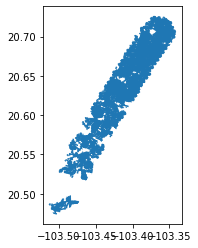

In [164]:
routes_bystreetgdf = routes_bystreetgdf.to_crs("EPSG:4326")
routes_bystreetgdf.plot()

## Saving to db.

In [165]:
aup.gdf_to_db_slow(routes_bystreetgdf,'rutastransporte_2km_bystreet','segundopiso',if_exists="replace")